# Capacitated Facility Location Problem - Version #1

The code kind of work atm. However, the constraints need to be improved. The problem is considered infeasible if not all of the farms can be assigned to a plant. 
https://www.youtube.com/watch?v=Ds5whiQXdbw&ab_channel=Hakeem-Ur-Rehman

Very weird.... the clustering effect of the model disappear after modification with the transport cost calculation. Why is it in the previous version when the amount transported from farm i to plant j is multiplied by the distance transported then clustering work? 

To do next - figure the above mentioned problem plus better visualization of results. Create a def function that separate out the farms not in solution and plants no in solution and better labeling of the plants. 

In [214]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [215]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.554937,52.254895,25
1,6.870686,52.215190,25
2,6.664105,52.392622,32
3,6.730518,52.252885,42
4,6.914234,52.387401,18


In [216]:
# Define the capacities of digester
medium_digester_capacity = 78480  # in tonne/yr
large_digester_capacity = 150560  # in tonne/yr

In [217]:
# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [218]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [219]:
# Create mock digester capacity data
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [220]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,7431,2898090.0
1,1,6.837249,52.425084,7246,2825940.0
2,2,6.859361,52.386225,9639,3759210.0
3,3,6.753483,52.434382,9821,3830190.0
4,4,6.484077,52.243620,2732,1065480.0


In [221]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # Customer = [1,2,3,4,5]
Plant = potential_digester_location.index.tolist()    # Facility = ['Fac-1', 'Fac-2', 'Fac-3']

In [222]:
# Dictionaries of the demands and facilities as well as fixed cost at each facility
Manure_Production = farm['manure_t'].to_dict()  # Demand = {1 : 80, 2 : 270, 3 : 250, 4 : 160, 5 : 180}
Max_Capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500} 
Fixed_Cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [223]:
type(Fixed_Cost.values())

dict_values

In [224]:
# string_values = {}
# non_string_values = {}

# for key, value in transportation_cost.items():
#     if isinstance(value, str):
#         string_values[key] = value
#     else:
#         non_string_values[key] = value

# print("String Values:")
# print(string_values)

# print("\nNon-String Values:")
# print(non_string_values)

In [225]:
from scipy.spatial.distance import euclidean

# # Dictionary of the transportation cost from each facility to all the customers 
# transportation_cost = {'Fac-1' : {1 : 4, 2 : 5, 3 : 6, 4 : 8, 5 : 10},
#                        'Fac-2' : {1 : 6, 2 : 4, 3 : 3, 4 : 5, 5 : 8},
#                        'Fac-3' : {1 : 9, 2 : 7, 3 : 4, 4 : 3, 5 : 4}
#                       }

# Create a mock distance matrix to store the euclidean distance between each potential digester location to every farm
transportation_cost = {} # NOTE THE TRANSPORTATION COST MATRIX IS A !DISTANCE MATRIX!

for plant_idx, plant_row in potential_digester_location.iterrows():
    plant_coords = (plant_row['y'], plant_row['x'])
    transportation_cost[plant_idx] = {}  # Create an inner dictionary for each plant

    for farm_idx, farm_row in farm.iterrows():
        farm_coords = (farm_row['y'], farm_row['x'])
        distance = euclidean(plant_coords, farm_coords)
        transportation_cost[plant_idx][farm_idx] = distance

# transportation_cost

In [226]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem_V2", LpMinimize)

In [227]:
# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary)    
    # use_facility = LpVariable.dicts("Use Facility", Facility, 0, 1, LpBinary)
ser_farm = LpVariable.dicts("Farm_Plant", [(i,j) for i in Farm for j in Plant], 0)  
    # ser_customer = LpVariable.dicts("Service", [(i,j) for i in Customer for j in Facility], 0)

In [228]:
# Create a binary variable to indicate if a farm supplies a plant
farm_supplies_plant = LpVariable.dicts("Farm_Supplies_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary)

In [229]:
# Create a scaling factor for the total distance value, so that total distance and fixed cost are weighted more equally in the objective function
alpha = 100000000

In [230]:
# Minimize total distance
total_distance = lpSum(transportation_cost[j][i] * farm_supplies_plant[(i, j)] for j in Plant for i in Farm)

In [231]:
# Setting the Objective Function
prob += (lpSum(Fixed_Cost[j] * use_plant[j] for j in Plant) + alpha * total_distance)

# prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)
# prob += lpSum(fixed_cost[j]*use_facility[j] for j in Facility) + lpSum(transportation_cost[j][i]*ser_customer[(i,j)] for j in Facility for i in Customer)

In [232]:
# for j in Plant:
#     for i in Farm:
#        print(transportation_cost[j][i]*ser_farm[(i,j)])

In [233]:
# # Costraints

# # This constraint controls that the facility should meet the demand of a customer in the example but in our case
# #     # this means the farm has to be able to send exactly the entire produced amount of manure to the assigned digester
for i in Farm: 
    # prob += lpSum(ser_farm[(i,j)] for j in Plant) == Manure_Production[i]
    prob += lpSum(ser_farm[(i, j)] for j in Plant) <= Manure_Production[i]


for j in Plant:
    prob += lpSum(ser_farm[(i,j)] for i in Farm) <= Max_Capacity[j]*use_plant[j]

for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= Manure_Production[i]*use_plant[j]

# Add a constraint to ensure at least 50% of total production is sent to plants
prob += lpSum(ser_farm[(i, j)] for i in Farm for j in Plant) >= 0.5 * Total_Manure_Production

In [234]:
for j in Plant:
    print(use_plant[j])

Plant_0
Plant_1
Plant_2
Plant_3
Plant_4


In [235]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze_env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/b546bd2c5a114412929b9fc40848aabf-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/b546bd2c5a114412929b9fc40848aabf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 1425 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 596177 - 0.00 seconds
Cgl0004I processed model has 858 rows, 715 columns (5 integer (5 of which binary)) and 3555 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.360013
Cbc0038I Pass   1: suminf.    0.36001 (1) obj. 596177 iterations 0
Cbc00

1

In [236]:
status = LpStatus[prob.status]


In [237]:
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [238]:
# if status == "Optimal":
#     # Retrieve and store the variable values
#     optimal_x = use_facility.varValue
#     optimal_y = ser_customer.varValue

#     # Retrieve and store the optimal objective value
#     optimal_obj_value = prob.objective.value()
# else:
#     optimal_x = None
#     optimal_y = None
#     optimal_obj_value = None

# print("Optimization Status:", status)
# print("Optimal x:", optimal_x)
# print("Optimal y:", optimal_y)
# print("Optimal Objective Value:", optimal_obj_value)

In [239]:
# # Print the status of the optimization
# print("Optimization Status:", LpStatus[prob.status])

# # Print the optimal values of decision variables
# for j in Facility:
#     print(f"Use Facility {j}: {use_facility[j].varValue}")

# for i in Customer:
#     for j in Facility:
#         print(f"Service customer {i} from Facility {j}: {ser_customer[(i, j)].varValue}")

In [240]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for j in Plant:
#     if use_plant[j].varValue > Tolerance:
#         print("Estalish Facility at site = ", j)

In [241]:
# Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [242]:
# Initialize lists to store assignment information
assigned_farms = {j: [] for j in Plant}

# Collect assigned farms
for i in Plant:
    for j in Farm:
        if ser_farm[(j,i)].varValue > 0.00001:
            assigned_farms[i].append(j)

assigned_farms

{0: [3, 19, 22, 37, 54, 58, 61, 71, 72, 79, 108, 113, 130],
 1: [],
 2: [],
 3: [7,
  21,
  36,
  38,
  40,
  41,
  49,
  50,
  51,
  55,
  59,
  62,
  63,
  64,
  65,
  74,
  81,
  86,
  92,
  96,
  97,
  98,
  101,
  117,
  122,
  124,
  127,
  129,
  133,
  138,
  140],
 4: [6,
  8,
  12,
  18,
  20,
  24,
  27,
  30,
  43,
  44,
  46,
  48,
  57,
  60,
  69,
  73,
  76,
  78,
  82,
  83,
  87,
  91,
  93,
  99,
  112,
  131,
  135,
  137]}

In [243]:
for j in Plant:
    assigned = assigned_farms[j]
    print(len(assigned))

13
0
0
31
28


In [244]:
for j in Plant:
    assigned = assigned_farms[j]
    print(assigned)

[3, 19, 22, 37, 54, 58, 61, 71, 72, 79, 108, 113, 130]
[]
[]
[7, 21, 36, 38, 40, 41, 49, 50, 51, 55, 59, 62, 63, 64, 65, 74, 81, 86, 92, 96, 97, 98, 101, 117, 122, 124, 127, 129, 133, 138, 140]
[6, 8, 12, 18, 20, 24, 27, 30, 43, 44, 46, 48, 57, 60, 69, 73, 76, 78, 82, 83, 87, 91, 93, 99, 112, 131, 135, 137]


In [245]:
# Creating a list of all farms that are not assigned a plant
assignment_to_check = []

# Append the lists from the dictionary to the combined list
for key in assigned_farms:
    assignment_to_check.extend(assigned_farms[key])

not_in_any_solution = []

for index_value in farm.index:
    if index_value not in assignment_to_check:
        not_in_any_solution.append(index_value)

    # for j in Plant:
    #     assigned = assigned_farms[j]
    #     if index_value not in assigned:
    #         not_in_any_solution.append(index_value)

PROBLEM!! The number of farms that are not_in_any_solution combined with all the farms that are included add up to 143, which is 1 more than the actual count of farms....

Just checked and *18* has duplicates. So Farm 18 is assigned to Plant 1 and 4. 


In [246]:
len(not_in_any_solution)

70

In [247]:
# Check duplicates

# Initialize a dictionary to store seen values
seen = {}
# Initialize a list to store duplicate values
duplicates = []

# Iterate through the list
for item in assignment_to_check:
    # If the item is already in the dictionary, it's a duplicate
    if item in seen:
        duplicates.append(item)
    else:
        seen[item] = True

if duplicates:
    print("Duplicate values:", duplicates)
else:
    print("There are no duplicates in the list.")

There are no duplicates in the list.


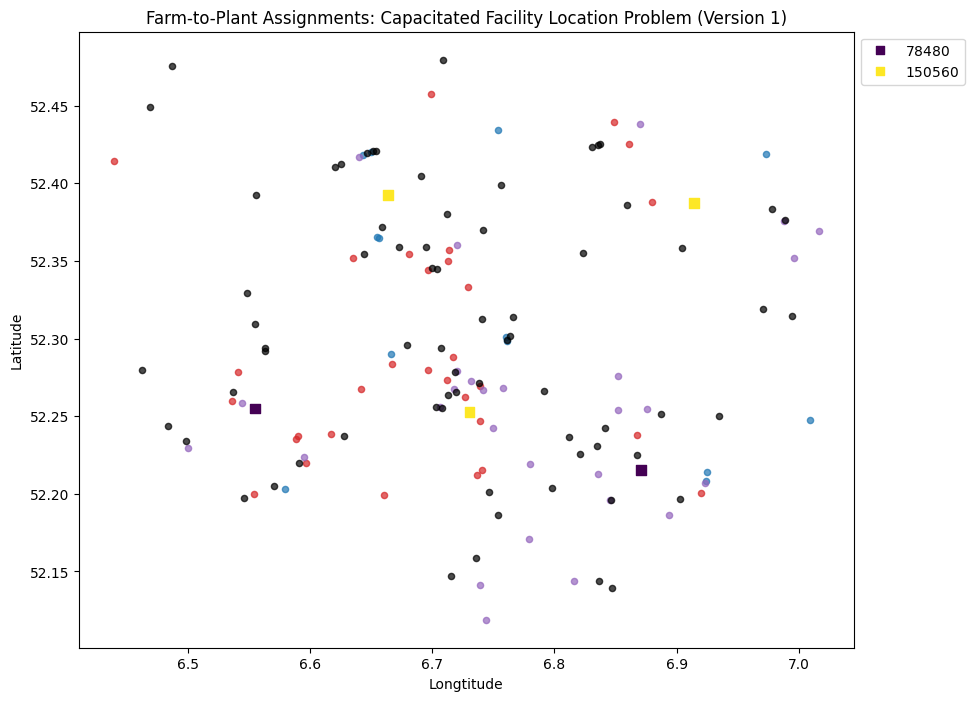

In [248]:
# Visualize the results
plt.figure(figsize=(10, 8))

for j in Plant:
    assigned = assigned_farms[j]
    plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Plant {j}", marker='o', s=20, alpha=0.7)
    # plt.scatter([potential_digester_location.iloc[j, "x"] for j in Plant], [potential_digester_location[j, "y"] for j in Plant], color='red', label="Plant Locations", marker='s', s=100)

for left_out in not_in_any_solution:
    plt.scatter(farm.loc[left_out, 'x'], farm.loc[left_out, 'y'], marker='o', s=20, c='Black', alpha=0.7)

scatter = plt.scatter(potential_digester_location['x'], potential_digester_location['y'], c=potential_digester_location['capacity'], label="Plant Locations", marker='s', s=50)
# Add labels based on 'Label' column
# for i, row in potential_digester_location.iterrows():
#     plt.annotate(row['capacity'], (row['x'], row['y']), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and legend
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.title("Farm-to-Plant Assignments: Capacitated Facility Location Problem (Version 1)")
# plt.legend()
legend = plt.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

# # Create a dictionary to map unique values to custom legend labels
# custom_labels = {'A': 'Category 1', 'B': 'Category 2', 'C': 'Category 3'}

# # Replace unique values with custom labels for the legend
# legend_labels = [custom_labels[label] for label in df['Label'].unique()]

# # Create the legend with custom labels
# legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# plt.savefig(r"./cflp_v1.png", dpi=300)

plt.show()

In [249]:
# Print Optimal
print("Total Cost = ", value(prob.objective))

Total Cost =  714481.0
